# Medical Specialty Classification with T5

T5 ("Text-to-Text Transfer Transformer") is an encoder-decoder based model which was shown to be useful for many NLP tasks.\
The base of the work is a pretrained model on a large scale English text dataset. In this notebook, we finetune  it to the task of medical specialty classification.


## Imports
The code is written using **PyTorch**. \
T5 implementation was taken from **transformers** library by [huggingface](https://github.com/huggingface/transformers).

In [1]:
# task imports
%matplotlib inline
import os
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hagaymi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# check if running on google colab
try:
  import google.colab
  IS_COLAB = True
except:
  IS_COLAB = False

if IS_COLAB:
  # from google.colab import drive
  # drive.mount('/content/drive')
  # root_dir = '/content/drive/MyDrive/projects/8200bio/Nym/'
  # install colab extensions
  ! pip3 install transformers
  ! pip install sentencepiece
  ! pip install gdown
# else:
#     root_dir = '/home/hagaymi/nym/'
root_dir = '.'
print("runs on google colab: ", IS_COLAB)
print("root dir: ", root_dir)

runs on google colab:  False
root dir:  .


In [3]:
# download dataset
! gdown --id 1OZrRN5jLkL73E_ZchJYe0cmNy-WPbj5-


Downloading...
From: https://drive.google.com/uc?id=1OZrRN5jLkL73E_ZchJYe0cmNy-WPbj5-
To: /home/hagaymi/nym/data.csv
100%|██████████████████████████████████████| 11.0M/11.0M [00:00<00:00, 17.6MB/s]


## Dataset
The dataset contains approx. 2000 transcriptions labled by medical specialty. \
It was provided by Nym during 8200bio challenge (Oct. 2021)

In [4]:
# load raw dataset
data = pd.read_csv(os.path.join(root_dir, 'data.csv'))
data.sample(2)


,transcription,specialty
3409,"DISCHARGE DIAGNOSES:,1. End-stage renal disea...",Nephrology
1774,"PREOPERATIVE DIAGNOSIS:, Left carpal tunnel s...",Orthopedic


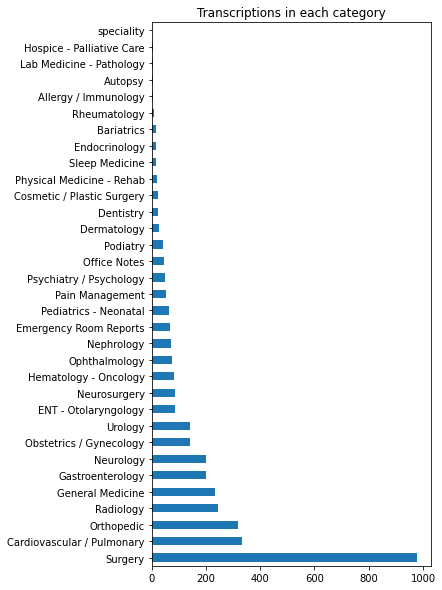

In [5]:
data.specialty.value_counts().plot(kind='barh',figsize=(5, 10), title='Transcriptions in each category' )
plt.show()


In [6]:
df = data.groupby('transcription').apply(lambda x: x['specialty'].values.tolist()).reset_index()
df.head()


,transcription,0
0,"1. Pelvic tumor.,2. Cystocele.,3. Rectocele...","[Obstetrics / Gynecology, Surgery, Urology]"
1,1. The left ventricular cavity size and wall ...,"[Cardiovascular / Pulmonary, Radiology]"
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[Cardiovascular / Pulmonary, Radiology]"
3,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[Cardiovascular / Pulmonary, Radiology]"
4,"3-DIMENSIONAL SIMULATION,This patient is under...","[Hematology - Oncology, Radiology]"


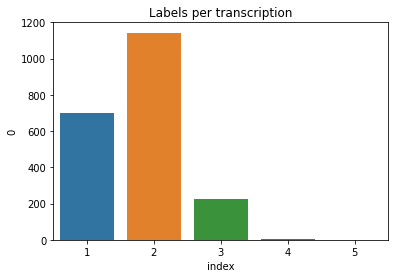

In [7]:
transcription_counts = data.groupby('transcription').size().value_counts().reset_index()
p = sns.barplot(data = transcription_counts, x='index', y=0).set(title='Labels per transcription')


## Data Preprocessing

We're using the raw transcription concatenated to the task decription: \
`classify specialties:`

#### Abstracts
- Stripping extra whitespaces around the text.
- Replacing escape characters with whitespace.
- Padding all punctuations with whitespaces on both sides.

#### Labels
Each transcription can have multiple lables, while each sample in the raw dataset has one label.
We cancel repeatations, and instead attach label list to every transcription.



In [8]:
# load data, initial preprocessing
data = pd.read_csv(os.path.join(root_dir, 'data.csv'))
data.head()

,transcription,specialty
0,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology
1,"CHIEF COMPLAINT: , This 5-year-old male presen...",Allergy / Immunology
2,"HISTORY: , A 34-year-old male presents today s...",Allergy / Immunology
3,"HISTORY:, I had the pleasure of meeting and e...",Allergy / Immunology
4,"SUBJECTIVE: , This is a 42-year-old white fema...",Allergy / Immunology


In [9]:
# fetch all labels
labels_list = data['specialty'].unique()
print("label list: ", labels_list)

# set labels lower case. for options like 'Allergy / Immunology'
# allow "partial labels" (e.g. 'Allergy'  'Immunology') 
labels_li_indices = dict()

for idx, label in enumerate(labels_list):
    labels_li_indices[label] = idx
    labels_li_indices[label.lower()] = idx
    if ' / ' in label:
        for l in label.split(' / '):
            labels_li_indices[l] = idx
            labels_li_indices[l.lower()] = idx
    labels_li_indices[label.replace(' ', '')] = idx
    labels_li_indices[label.lower().replace(' ', '')] = idx
    
          
print("labels dict: ", labels_li_indices)


label list:  ['Allergy / Immunology' 'Autopsy' 'Bariatrics'
 'Cardiovascular / Pulmonary' 'Cosmetic / Plastic Surgery' 'Dentistry'
 'Dermatology' 'ENT - Otolaryngology' 'Emergency Room Reports'
 'Endocrinology' 'Gastroenterology' 'General Medicine'
 'Hematology - Oncology' 'Hospice - Palliative Care'
 'Lab Medicine - Pathology' 'Nephrology' 'Neurology' 'Neurosurgery'
 'Obstetrics / Gynecology' 'Office Notes' 'Ophthalmology' 'Orthopedic'
 'Pain Management' 'Pediatrics - Neonatal' 'Physical Medicine - Rehab'
 'Podiatry' 'Psychiatry / Psychology' 'Radiology' 'Rheumatology'
 'Sleep Medicine' 'Surgery' 'Urology' 'speciality']
labels dict:  {'Allergy / Immunology': 0, 'allergy / immunology': 0, 'Allergy': 0, 'allergy': 0, 'Immunology': 0, 'immunology': 0, 'Allergy/Immunology': 0, 'allergy/immunology': 0, 'Autopsy': 1, 'autopsy': 1, 'Bariatrics': 2, 'bariatrics': 2, 'Cardiovascular / Pulmonary': 3, 'cardiovascular / pulmonary': 3, 'Cardiovascular': 3, 'cardiovascular': 3, 'Pulmonary': 3, 'pul

In [10]:
# unify duplicated text and set label list
train_df = data.groupby('transcription').apply(lambda x: x['specialty'].values.tolist()).reset_index()
train_df.head()


,transcription,0
0,"1. Pelvic tumor.,2. Cystocele.,3. Rectocele...","[Obstetrics / Gynecology, Surgery, Urology]"
1,1. The left ventricular cavity size and wall ...,"[Cardiovascular / Pulmonary, Radiology]"
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[Cardiovascular / Pulmonary, Radiology]"
3,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[Cardiovascular / Pulmonary, Radiology]"
4,"3-DIMENSIONAL SIMULATION,This patient is under...","[Hematology - Oncology, Radiology]"


In [11]:
# preprocessing
def clean_abstract(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    return text
    

def get_texts(df):
    # texts = 'multilabel classification: ' + df['ABSTRACT'].apply(clean_abstract)
    texts = 'classify specialties: ' + df['transcription'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts


def get_labels(df):
    labels = df[0].apply(', '.join)
    labels = labels.values.tolist()

    # labels =  
    return labels


texts = get_texts(train_df)
labels = get_labels(train_df)

for text, label in zip(texts[:2], labels[:2]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

TEXT -	classify specialties: 1 .  Pelvic tumor .  , 2 .  Cystocele .  , 3 .  Rectocele .  , POSTOPERATIVE DIAGNOSES: , 1 .  Degenerated joint .  , 2 .  Uterine fibroid .  , 3 .  Cystocele .  , 4 .  Rectocele .  , PROCEDURE PERFORMED:  , 1 .  Total abdominal hysterectomy .  , 2 .  Bilateral salpingooophorectomy .  , 3 .  Repair of bladder laceration .  , 4 .  Appendectomy .  , 5 .  Marshall-Marchetti-Krantz cystourethropexy .  , 6 .  Posterior colpoperineoplasty .  , GROSS FINDINGS: The patient had a history of a rapidly growing mass on the abdomen ,  extending from the pelvis over the past two to three months .  She had a recent D&C and laparoscopy ,  and enlarged mass was noted and could not be determined if it was from the ovary or the uterus .  Curettings were negative for malignancy .  The patient did have a large cystocele and rectocele ,  and a collapsed anterior and posterior vaginal wall .  , Upon laparotomy ,  there was a giant uterine tumor extending from the pelvis up to the

## Exploratory Data Analysis

(array([262., 582., 493., 335., 195.,  99.,  52.,  28.,  10.,  11.,   4.,
          3.,   0.,   1.,   1.]),
 array([   3.        ,  201.13333333,  399.26666667,  597.4       ,
         795.53333333,  993.66666667, 1191.8       , 1389.93333333,
        1588.06666667, 1786.2       , 1984.33333333, 2182.46666667,
        2380.6       , 2578.73333333, 2776.86666667, 2975.        ]),
 <BarContainer object of 15 artists>)

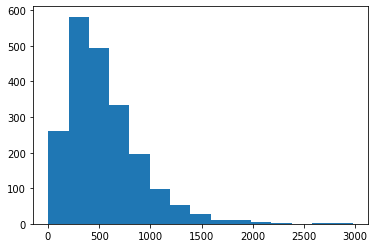

In [12]:
# text lengths
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.hist(y, bins=15)

(array([298., 750., 387., 458.,  84.,  59.,  31.,   5.,   3.,   1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

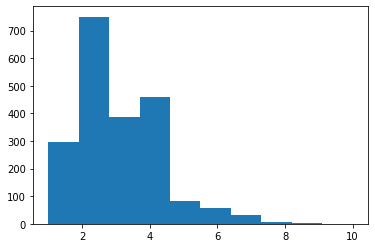

In [13]:
# label lengths
y = [len(l.split()) for l in labels]
x = range(0, len(y))
plt.hist(y)


We chose 512 for **src MAX_LENGTH** and 16 for **tgt MAX_LENGTH** 
- src - transcription 
- tgt - labels (specialties)


## Config
Class defining hyper paramters, etc.

In [14]:
# # small x1
# class Config:
#     def __init__(self):
#         super(Config, self).__init__()

#         self.SEED = 42
#         self.MODEL_PATH = 't5-small'

#         # data
#         self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
#         self.SRC_MAX_LENGTH = 512
#         self.TGT_MAX_LENGTH = 16
#         self.BATCH_SIZE = 16
#         self.VALIDATION_SPLIT = 0.25

#         # model
#         self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         self.FULL_FINETUNING = True
#         self.LR = 3e-5
#         self.OPTIMIZER = 'AdamW'
#         self.CRITERION = 'BCEWithLogitsLoss'
#         self.SAVE_BEST_ONLY = True
#         self.N_VALIDATE_DUR_TRAIN = 1
#         self.EPOCHS = 20

# base x1
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 't5-base'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 512
        self.TGT_MAX_LENGTH = 16
        self.BATCH_SIZE = 1
        self.GRAD_ACCUM = 1
        self.VALIDATION_SPLIT = 0.2
        

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 1
        self.EPOCHS = 20

config = Config()

## Dataset & Dataloader

create a custom Dataset class using PyTorch Dataset class. We'll be using the **T5 tokenizer** that returns **input_ids** and **attention_mask**.\
The custom Dataset class will return a dict containing - <br>

- src_input_ids
- src_attention_mask
- tgt_input_ids
- tgt_attention_mask

In [15]:
class T5Dataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                # pad_to_max_length=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

**T5Dataset** Class takes as input the **dataframe**, **indices** & **set_type**. 
We use indices list to split train / val sets.

In [16]:
# train-val split

np.random.seed(config.SEED)

dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(config.VALIDATION_SPLIT * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

Here we'll initialize PyTorch DataLoader objects for the training & validation data.<br>
These dataloaders allow us to iterate over them during training, validation or testing and return a batch of the Dataset class outputs.

In [17]:
train_data = T5Dataset(train_df, train_indices)
val_data = T5Dataset(train_df, val_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([1, 512])
src_attention_mask shape: torch.Size([1, 512])
tgt_input_ids shape: torch.Size([1, 16])
tgt_attention_mask shape: torch.Size([1, 16])


## Model
Our model uses pretrained T5 model with a Conditional Generation Head, from Huggingface transformers library.

In [18]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            # lm_labels=lm_labels,
            labels=lm_labels,
        )

In [20]:
device = config.DEVICE
device

device(type='cuda')

## Engine

Our engine consists of the training and validation step functions.

In [21]:

def get_ohe(x):
    clean_x = [xl.replace('<pad>', '').replace('</s>', '').replace(' ', '') for xl in x]
    y = [labels.split(',') for labels in clean_x]
    ohe = []
    for labels in y:
        # print("predicted labels: ", labels)
        temp = [0] * len(labels_list)
        for label in labels:
            idx = labels_li_indices.get(label.lower(), -1)
            # print("label: ", label, "idx: ", idx)
            if idx != -1:
                temp[idx] = 1
        ohe.append(temp)
    ohe = np.array(ohe)
    return ohe


We use F1 score for evaluation. We calculate both micro and macro, but our target is to maximize macro f1, which gives equal weight to rare and common specialties. \
Since the dataset is highly imbalanced, we may see large difference between the two metrics.


In [37]:
def val(model, val_dataloader, criterion, label_stats=False):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)
    
    if label_stats:
        true_count = np.sum(true_ohe, axis=0)
        pred_count = np.sum(pred_ohe, axis=0)
        labels = [i for i in range(len(true_count))]
        plt.bar(labels, true_count, label='true specialties count')
        plt.bar(labels, pred_count, label='pred specialties count')

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    val_macro_f1_score = f1_score(true_ohe, pred_ohe, average='macro')
    print('Val micro f1 score:', val_micro_f1_score)
    print('Val macro f1 score:', val_macro_f1_score)
    return val_micro_f1_score, val_macro_f1_score



In [24]:
def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    
    train_loss = 0
    optimizer.zero_grad()
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        

        loss = outputs[0] 
        train_loss += loss.item()
        
        #  average loss (grad accum.)
        loss = loss / config.GRAD_ACCUM

        # backward pass
        loss.backward()
        
        if step % config.GRAD_ACCUM == 0:
            # update weights
            optimizer.step()
            optimizer.zero_grad()

        # update scheduler
        scheduler.step()

        
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

## Run

### Loss function
- **BCEWithLogitsLoss** - Most commonly used loss function for Multi Label Classification tasks. 

### Optimizer
- **AdamW** - Commonly used optimizer. Similar to the AdaFactor that was used in T5 paper.

### Scheduler
- **get_linear_scheduler_with_warmup** from the **transformers** library.


In [25]:
def run():
    print("run training")
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    max_val_macro_f1_score = 0
    print("start training:")
    for epoch in range(config.EPOCHS):
        print("train epoch:")
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        print("evaluate:")
        val_micro_f1_score, val_macro_f1_score = val(model, val_dataloader, criterion)
        print("dummy test:")
        dummy_test(model, config.TOKENIZER)
        
        if config.SAVE_BEST_ONLY:
            if val_macro_f1_score > max_val_macro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_macro_f1_score = val_macro_f1_score
                

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_macro_f1_score} -> {val_macro_f1_score}')
                max_val_macro_f1_score = val_macro_f1_score

    return best_model, best_val_macro_f1_score

In [26]:
model = T5Model()
model.to(device);

Dummy test for sanity check during training

In [27]:
def dummy_test(model, tokenizer):
    model.eval()
    inputs = ["Calssify specialties: The patient had a heart attack.",
             "Classify specialties: The patient is a 5 year old girl, complaining about headack."]
    for transcription in inputs:
        inp = tokenizer.encode_plus(transcription,
                                    max_length=config.SRC_MAX_LENGTH,
                                    padding='max_length',
                                    # pad_to_max_length=True,
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_token_type_ids=False,
                                    return_tensors='pt'
                                    )
        # print(inp)
        src_input_ids = inp['input_ids'].to(device)
        src_attention_mask = inp['attention_mask'].to(device)

        with torch.no_grad():
            pred_ids = model.t5_model.generate(
                input_ids=src_input_ids, 
                attention_mask=src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            pred_decoded = tokenizer.decode(pred_ids[0])

        print("input: ", transcription)
        print("output: ", pred_decoded)

    
dummy_test(model, config.TOKENIZER)

input:  Calssify specialties: The patient had a heart attack.
output:  <pad> <extra_id_0> : The patient had a heart attack.<extra_id_1> : The patient had a heart attack
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> <extra_id_0> :<extra_id_1> : Classify specialties:<extra_id_2> : The patient is a 5 year old


In [26]:
best_model, best_val_macro_f1_score = run()

run training
start training:
train epoch:


Epoch 0:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.8385336945166454
evaluate:
Val loss: 0.4249023879867002
Val accuracy: 0.43614457831325304
Val micro f1 score: 0.6899696048632219
Val macro f1 score: 0.3193499469253828
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


--- Best Model. Val loss: 0 -> 0.3193499469253828
train epoch:


Epoch 1:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.3941785768579977
evaluate:
Val loss: 0.3358515584137268
Val accuracy: 0.5349397590361445
Val micro f1 score: 0.7480482611781405
Val macro f1 score: 0.45544548794756895
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


--- Best Model. Val loss: 0.3193499469253828 -> 0.45544548794756895
train epoch:


Epoch 2:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.2906024074703716
evaluate:
Val loss: 0.3151725315522537
Val accuracy: 0.5518072289156627
Val micro f1 score: 0.7736804049168474
Val macro f1 score: 0.5107603659908908
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Orthopedic</s>
--- Best Model. Val loss: 0.45544548794756895 -> 0.5107603659908908
train epoch:


Epoch 3:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.21943543550348055
evaluate:
Val loss: 0.2846852308934476
Val accuracy: 0.5975903614457831
Val micro f1 score: 0.8014545454545455
Val macro f1 score: 0.5276619987502772
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


--- Best Model. Val loss: 0.5107603659908908 -> 0.5276619987502772
train epoch:


Epoch 4:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.16886430776527056
evaluate:
Val loss: 0.29444158515266666
Val accuracy: 0.619277108433735
Val micro f1 score: 0.8031609195402298
Val macro f1 score: 0.5664377246660679
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
--- Best Model. Val loss: 0.5276619987502772 -> 0.5664377246660679
train epoch:


Epoch 5:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.13692955300506712
evaluate:
Val loss: 0.3004136741918046
Val accuracy: 0.6144578313253012
Val micro f1 score: 0.8140556368960469
Val macro f1 score: 0.5717755706748608
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>
--- Best Model. Val loss: 0.5664377246660679 -> 0.5717755706748608
train epoch:


Epoch 6:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.10974250271372195
evaluate:
Val loss: 0.3225993276744045
Val accuracy: 0.6481927710843374
Val micro f1 score: 0.8224431818181818
Val macro f1 score: 0.5911512523594658
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


--- Best Model. Val loss: 0.5717755706748608 -> 0.5911512523594658
train epoch:


Epoch 7:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.08233861585834729
evaluate:
Val loss: 0.33574699894630744
Val accuracy: 0.6602409638554216
Val micro f1 score: 0.837473385379702
Val macro f1 score: 0.6262702075853831
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
--- Best Model. Val loss: 0.5911512523594658 -> 0.6262702075853831
train epoch:


Epoch 8:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.07389040616252923
evaluate:
Val loss: 0.348416161140451
Val accuracy: 0.6313253012048192
Val micro f1 score: 0.8134863701578191
Val macro f1 score: 0.5849918456599277
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 9:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.06426471021385449
evaluate:
Val loss: 0.37814224199982743
Val accuracy: 0.6289156626506024
Val micro f1 score: 0.8147612156295224
Val macro f1 score: 0.6072968473739686
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 10:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.047367632667333466
evaluate:
Val loss: 0.3671876223452229
Val accuracy: 0.6433734939759036
Val micro f1 score: 0.822695035460993
Val macro f1 score: 0.6046047775966376
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 11:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.04244397023404313
evaluate:
Val loss: 0.37474984023706437
Val accuracy: 0.6433734939759036
Val micro f1 score: 0.8217609162491053
Val macro f1 score: 0.609781955316902
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 12:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.03401028180288624
evaluate:
Val loss: 0.38349244181450143
Val accuracy: 0.6506024096385542
Val micro f1 score: 0.8288920056100981
Val macro f1 score: 0.6297593090136293
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


--- Best Model. Val loss: 0.6262702075853831 -> 0.6297593090136293
train epoch:


Epoch 13:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.031005937397028022
evaluate:
Val loss: 0.3925453853230268
Val accuracy: 0.6457831325301204
Val micro f1 score: 0.8272921108742004
Val macro f1 score: 0.6127021182049807
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 14:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.02344069308011643
evaluate:
Val loss: 0.4200558671619355
Val accuracy: 0.6481927710843374
Val micro f1 score: 0.8294736842105263
Val macro f1 score: 0.6265803510713274
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 15:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.021346518578800672
evaluate:
Val loss: 0.412597765048988
Val accuracy: 0.6433734939759036
Val micro f1 score: 0.8239436619718309
Val macro f1 score: 0.6151040863944025
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 16:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.017905857973524113
evaluate:
Val loss: 0.4262377683112681
Val accuracy: 0.653012048192771
Val micro f1 score: 0.829639889196676
Val macro f1 score: 0.6292913960491519
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 17:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.014011861460327889
evaluate:
Val loss: 0.43268926860948986
Val accuracy: 0.653012048192771
Val micro f1 score: 0.8305555555555555
Val macro f1 score: 0.6294737333955391
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> Neurology</s>
train epoch:


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 18:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.0135937547616771
evaluate:
Val loss: 0.4460605543904339
Val accuracy: 0.6506024096385542
Val micro f1 score: 0.8293020041465101
Val macro f1 score: 0.6352388885151725
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


--- Best Model. Val loss: 0.6297593090136293 -> 0.6352388885151725
train epoch:


Epoch 19:   0%|          | 0/1661 [00:00<?, ?it/s]

Training loss: 0.012089074333362418
evaluate:
Val loss: 0.4382678328608952
Val accuracy: 0.6674698795180722
Val micro f1 score: 0.8370473537604456
Val macro f1 score: 0.639998443989698
dummy test:
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>
--- Best Model. Val loss: 0.6352388885151725 -> 0.639998443989698


In [28]:
print("best macro f1: ", best_val_macro_f1_score) 
dummy_test(best_model, config.TOKENIZER)

best macro f1:  0.639998443989698
input:  Calssify specialties: The patient had a heart attack.
output:  <pad> Cardiovascular / Pulmonary</s>
input:  Classify specialties: The patient is a 5 year old girl, complaining about headack.
output:  <pad> General Medicine</s>


## Submission
Download and evaluate submission model

In [29]:
# doenload trained model
# https://drive.google.com/file/d/1ONzcbO06kIzrA5t8W-os7Jp-jvwXNb0Y/view?usp=sharing
# https://drive.google.com/file/d/1ONzcbO06kIzrA5t8W-os7Jp-jvwXNb0Y/view?usp=sharing
!gdown --id 1ONzcbO06kIzrA5t8W-os7Jp-jvwXNb0Y

In [32]:
submission_model = T5Model()
submission_model.load_state_dict(torch.load('t5_submission_model.pt'))
submission_model.to(device)

T5Model(
  (t5_model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseReluDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feature

In [33]:
# evaluation samples

# evaluate
def eval_sample(model):
    for i, batch in enumerate(val_dataloader):
        pred = []
        true = []
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
        b_tgt_input_ids = batch['tgt_input_ids']

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)


        for true_id in b_tgt_input_ids:
            true_decoded = config.TOKENIZER.decode(true_id)
            true.append(true_decoded)


        print("predictions: ", pred_decoded, " ground truths: ", true)
        if i > 10: break


eval_sample(submission_model)

predictions:  <pad> Ophthalmology, Surgery</s>  ground truths:  ['Ophthalmology, Surgery</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
predictions:  <pad> Ophthalmology, Surgery</s>  ground truths:  ['Ophthalmology, Surgery</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
predictions:  <pad> Cardiovascular / Pulmonary, Surgery</s>  ground truths:  ['Cardiovascular / Pulmonary, Surgery</s> <pad> <pad> <pad> <pad> <pad> <pad>']
predictions:  <pad> General Medicine</s>  ground truths:  ['General Medicine</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
predictions:  <pad> Gastroenterology, Surgery</s>  ground truths:  ['Gastroenterology, Surgery</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
predictions:  <pad> Neurology</s>  ground truths:  ['Neurology</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
predictions:  <pad> Surgery, Urology</s>  ground truths:  ['Surgery, Urology</s> <pad> <

Val loss: 0.4382678328608952
Val accuracy: 0.6674698795180722
Val micro f1 score: 0.8370473537604456
Val macro f1 score: 0.639998443989698


/home/hagaymi/nym/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


(0.8370473537604456, 0.639998443989698)

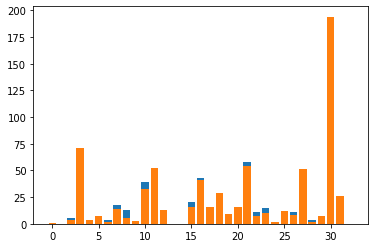

In [38]:
# evaluate submission F1 on validation set:
val(submission_model, val_dataloader, nn.BCEWithLogitsLoss(), label_stats=True)


# References:
- notebook: "T5 - Multi Label Classification"
https://www.kaggle.com/prithvijaunjale/t5-multi-label-classification

- HuggingFace transformers:
https://huggingface.co/transformers/

- T5 paper
https://arxiv.org/abs/1910.10683

- Nym
https://nym.health/

